# Decompose the Bering Strait velocity/transport terms into the geostrophic, barotropic, and residual

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
from glob import glob
import xarray as xr
from xgcm import Grid
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
import numpy as np
import cmocean

## Set paths

In [3]:
## CMIP6 CM4
# base
base_cmip6 = '/archive/oar.gfdl.cmip6/CM4/warsaw_201710_om4_v1.0.1/'
# pi
cmip6_PI = base_cmip6 + 'CM4_piControl_C/gfdl.ncrc4-intel16-prod-openmp/pp/'
# CM4 historical
cmip6_HI = base_cmip6 + 'CM4_historical/gfdl.ncrc4-intel16-prod-openmp/pp/'

In [4]:
# base for high res experiments
base_hres = '/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/'
## ODiv 209
# 1/8 degree MOM6 ocean with c192 atmosphere with remap scheme = P1M_H2 and MLE decay time at 20 days and 
# ice-albedo +1.0 tuning and land ice tuning F_iso = 0.8
odiv209_PI = base_hres + 'CM4_piControl_c192_OM4p125_v7/gfdl.ncrc4-intel18-prod-openmp/pp/'
## ODiv 210
# 1/4 degree MOM6 ocean with c192 atmosphere with remap scheme = P1M_H2 and MLE decay time at 20 days and 
# ice-albedo +1.0 tuning and land ice tuning F_iso = 0.8
odiv210_PI = base_hres + 'CM4_piControl_c192_OM4p25_v7/gfdl.ncrc4-intel18-prod-openmp/pp/'

In [5]:
## OM4 with JRA forcing
# base
base_om4 = '/archive/Raphael.Dussin/xanadu_esm4_20190304_mom6_2019.08.08/'
# historical
om4_HI = base_om4 + 'OM4p25_JRA55do1.4_0netfw_cycle6/gfdl.ncrc4-intel16-prod/pp/'

## Load and preprocess data

In [6]:
def open_model_data(flist):
    # open and clean up model data
    DS = xr.open_mfdataset(flist,use_cftime=True,combine='by_coords',engine='netcdf4',
                           drop_variables=['average_DT', 'average_T1', 'average_T2'])
    # Clean up coordinate names
    crds2chng = [match for match in list(DS.coords) if "_sub01" in match]
    for i in crds2chng:
        DS = DS.rename_dims({i:i[:2]}).rename({i:i[:2]})
    
    # Clean up variables with duplicate coords
    if "xh_sub02" in list(DS.coords):
        DS = DS.assign_coords(xh=("xh_sub02", DS.xh)).swap_dims({"xh_sub02": "xh"})
        DS = DS.drop_vars('xh_sub02')
    
    # Deal with padded zeros in xh
    if 'xh' in list(DS.coords):
        DS = DS.where(DS.xh!=0,drop=True)
        
    # Drop empty xh points
    xh_keep = DS.so.dropna('xh',how='all').xh
    DS = DS.sel(xh=xh_keep)
    
    return DS

def preproc_data(path):
    # Get pp output dir
    pp_dir = path + 'ocean_Bering_Strait/ts/daily/*yr/'
    # gateway file list
    flist = glob(f'{pp_dir}*.nc')
    
    # open the data and clean up
    DS = open_model_data(flist)
    
    # open the static file
    OS = xr.open_dataset(path + 'ocean_Bering_Strait/ocean_Bering_Strait.static.nc',
                         engine='netcdf4'
                        ).sel(xq=slice(DS.xh[0],
                                       DS.xh[-1]-(DS.xh[-2]-DS.xh[-1]))
                             ).sel(xh=DS.xh,yq=DS.yq,yh=DS.yh)
    
    # merge OS into DS
    DS = xr.merge([DS, OS])
    
    # make grid for Bering Strait section
    grid = Grid(DS,
                coords={'X': {'center': 'xh', 'right': 'xq'},
                        'Y': {'center': 'yh', 'right': 'yq'},
                        'Z': {'center': 'z_l', 'outer': 'z_i'} },
                periodic=['Y'])
    
    return DS, grid

## Calc $v_{geo}$ and $v_{barotropic}$

In [7]:
def pdens(S,theta,local=True):
    """Calculate potential density [in kg m-3] referenced to the surface according to the 
    expressions from Wright 1997, J. Atmos. Ocean. Tech., 14, 735 - 740.
    
    This is the computation for potential density used within MOM6
    
    Parameters
    ----------
    salt : xarray.DataArray
        Data Array containing salinity in psu
    theta: xarray.DataArray
        Data Array containing potential temperature relative to the sea surface in degree C
        
    Returns
    ----------
    xarray.DataArray
        Data Array containing potential density in kg m-3"""

    # --- Define constants (Table 1 Column 4, Wright 1997, J. Ocean Tech.)---
    a0 = 7.057924e-4
    a1 = 3.480336e-7
    a2 = -1.112733e-7

    b0 = 5.790749e8
    b1 = 3.516535e6
    b2 = -4.002714e4
    b3 = 2.084372e2
    b4 = 5.944068e5
    b5 = -9.643486e3

    c0 = 1.704853e5
    c1 = 7.904722e2
    c2 = -7.984422
    c3 = 5.140652e-2
    c4 = -2.302158e2
    c5 = -3.079464

    # To compute potential density keep pressure p = 100 kpa (100000 Pa) 
    # --- approx. sea level pressure.
    # S in standard salinity units psu, theta in DegC, p in pascals

    if local == True:
        ### Depth is in m, for Boussinesque depth == pressure in dbar, 
        ### dbar to Pa is dbar*10,000, add sea level [pressure to this]
        p = S.z_l*10000  + 100000  
    else: p = 100000.              ### Sea level pressure

    alpha0 = a0 + a1*theta + a2*S
    p0 = b0 + b1*theta + b2*theta**2 + b3*theta**3 + b4*S + b5*theta*S
    lambd = c0 + c1*theta + c2*theta**2 + c3*theta**3 + c4*S + c5*theta*S

    pot_dens = (p + p0)/(lambd + alpha0*(p + p0))

    return pot_dens

def decomp_v(DS,grid):
    # Gravity
    g = 9.81
    # Reference density [m2/s]
    rho0 = 1035.
    
    # calculate density
    DS['rho'] = pdens(DS.so,DS.thetao)
    # interpolate to u points
    DS['rho_u'] = grid.interp(DS.rho,'X',boundary='extend').chunk(chunks=-1)
    # interpolate to f points
    DS['rho_f'] = grid.interp(DS.rho_u,'Y')
    
    # calculate density gradients
    drho_dx = grid.diff(DS.rho_f,'X',boundary='extend') * DS.dxCv / DS.areacello_cv
    
    # interpolate f onto v points
    f = grid.interp(DS.Coriolis,'X',boundary='extend'
                   ).expand_dims(dim={"time": DS.time,"z_l": DS.z_l})
    
    # calc cell thickness
    DS['dz'] = grid.interp(DS.volcello / DS.areacello,'Y')
    # calc geostrophic shear
    dvg = -(g/f) * drho_dx * DS.dz / rho0
    
    # intergrate from bottom up
    DS['vo_g'] = dvg.reindex(z_l=dvg.z_l[::-1]).cumsum('z_l').reindex(z_l=dvg.z_l).chunk(chunks=-1)
    
    # calc barotropic velocity
    DS['vo_bt'] = DS.vo.isel(z_l=(DS.vo.isel(time=0).notnull() * DS.z_l).argmax(
        dim='z_l').drop('time').compute()).drop('z_l').expand_dims(dim={"z_l": DS.z_l}) * DS.vo.notnull()
    
    return DS

## Do the calc

In [8]:
DS, grid = preproc_data(om4_HI)

In [9]:
DS = decomp_v(DS,grid)

## test plots

In [10]:
vmm = 0.25

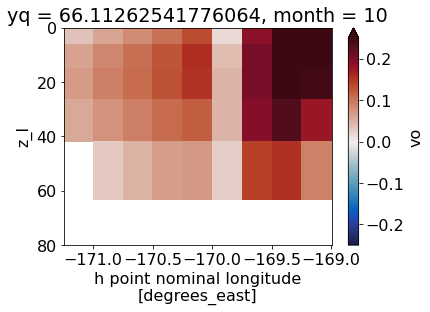

In [22]:
DS.vo.groupby('time.month').mean().sel(month=10).plot(yincrease=False,vmin=-vmm,vmax=vmm,cmap='cmo.balance')
plt.ylim(80,0)
plt.show()

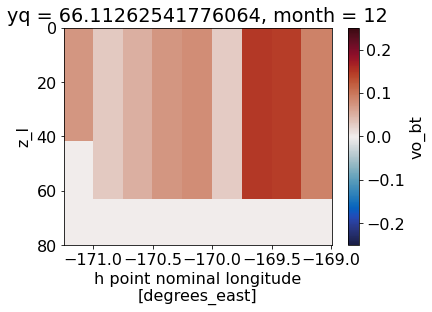

In [11]:
DS.vo_bt.groupby('time.month').mean().sel(month=12).plot(yincrease=False,vmin=-vmm,vmax=vmm,cmap='cmo.balance')
plt.ylim(80,0)
plt.show()

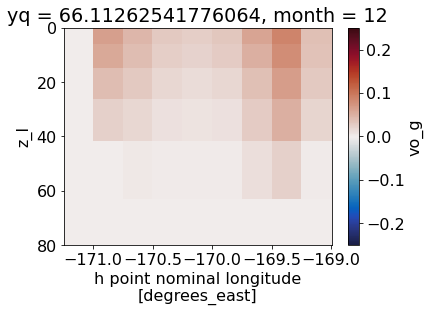

In [12]:
DS.vo_g.groupby('time.month').mean().sel(month=12).plot(yincrease=False,vmin=-vmm,vmax=vmm,cmap='cmo.balance')
plt.ylim(80,0)
plt.show()

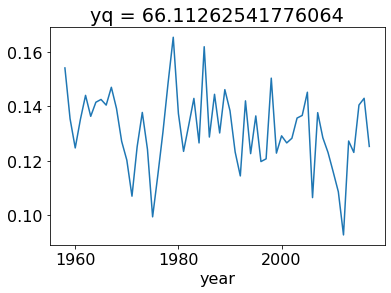

In [13]:
(1e-6 * DS.vo_g * DS.dz * DS.dxCv).sum(['xh','z_l']).groupby('time.year').mean().plot()

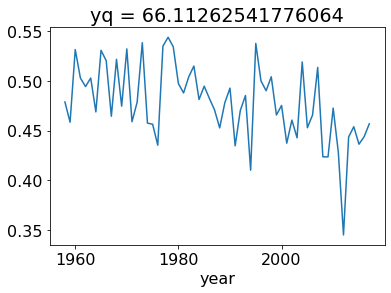

In [14]:
(1e-6 * DS.vo_bt * DS.dz * DS.dxCv).sum(['xh','z_l']).groupby('time.year').mean().plot()

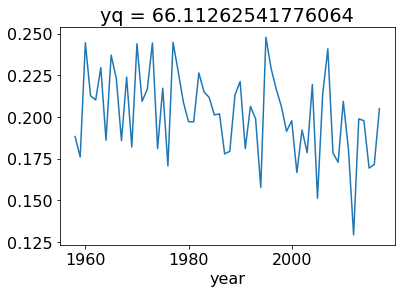

In [15]:
(1e-6 * (DS.vo - DS.vo_g - DS.vo_bt) * DS.dz * DS.dxCv).sum(['xh','z_l']).groupby('time.year').mean().plot()

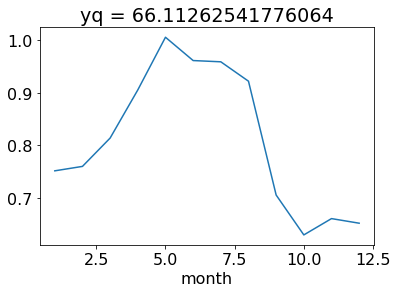

In [17]:
(1e-6 * DS.vo * DS.dz * DS.dxCv).sum(['xh','z_l']).squeeze().groupby('time.month').mean().plot()

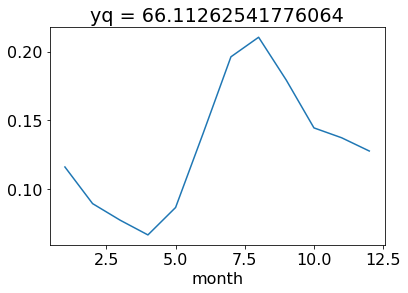

In [16]:
(1e-6 * DS.vo_g * DS.dz * DS.dxCv).sum(['xh','z_l']).squeeze().groupby('time.month').mean().plot()

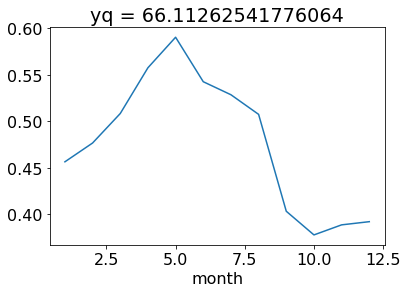

In [18]:
(1e-6 * DS.vo_bt * DS.dz * DS.dxCv).sum(['xh','z_l']).squeeze().groupby('time.month').mean().plot()

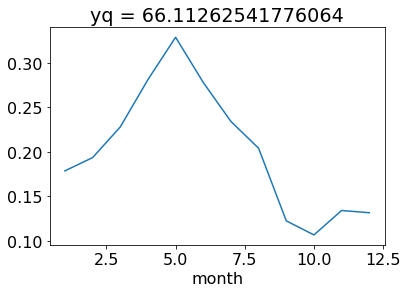

In [19]:
(1e-6 * (DS.vo - DS.vo_g - DS.vo_bt) * DS.dz * DS.dxCv).sum(['xh','z_l']).squeeze().groupby('time.month').mean().plot()

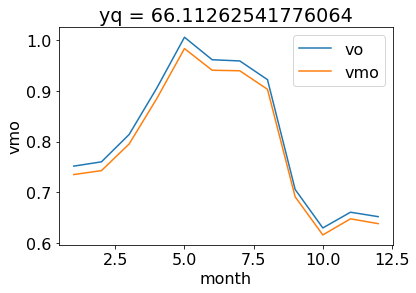

In [13]:
(1e-6 * DS.vo * DS.dz * OS.dxCv).sum(['xh','z_l']).squeeze().groupby('time.month').mean().plot(label='vo')
(1e-6 * DS.vmo/1035).sum(['xh','z_l']).squeeze().groupby('time.month').mean().plot(label='vmo')
plt.legend()

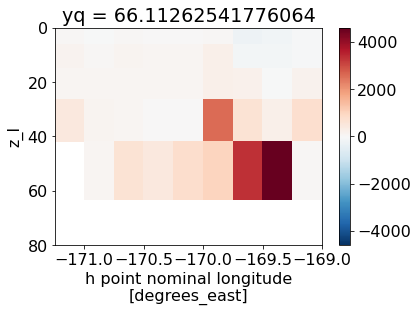

In [17]:
((DS.vo * DS.dz * OS.dxCv) - (DS.vmo/1035)).mean('time').plot(yincrease=False)
plt.ylim(80,0)
plt.show()

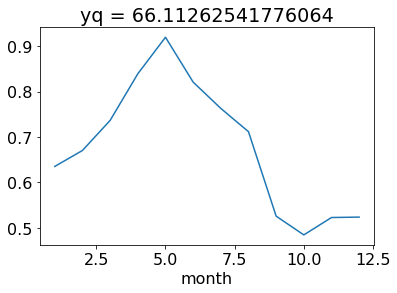

In [56]:
(1e-6 * (DS.vo - vg) * dz * OS.dxCv).sum(['xh','z_l']).squeeze().groupby('time.month').mean().plot()